# 🍍 LibriBrain Competition: Getting started (Speech Detection)
Welcome! This Notebook is the entrypoint into the [LibriBrain](https://libribrain.com/) competition hosted by the [PNPL](pnpl.robots.ox.ac.uk/) at NeurIPS 2025.

It will walk you through
1. setting up all necessary dependencies,
2. downloading training data, and
3. training a scaled down version of the simplest track of the competition

It is fully functional in the Colab Free Tier, though training will of course be faster with more GPU horsepower. With default settings on a `T4` instance, the main training run should take no more than 45 minutes.

In case of any questions or problems, please get in touch through [our Discord server](https://neural-processing-lab.github.io/2025-libribrain-competition/links/discord).

⚠️ **Notes**:
- If you want to speed up model training, **make sure you are on a GPU runtime by clicking Runtime -> Change runtime type**. TPU acceleration is currently not supported.
- We have only comprehensively validated the notebook to work on Colab and Unix. Your experience in other environments (e.g., Windows) may vary.

## Setting up dependencies
Run the code below *as is*. It will download all required dependencies, including our own [PNPL](https://pypi.org/project/pnpl/) package. On Windows, you might have to restart your Kernel after the installation has finished.

In [2]:
# Install additional depdendencies
%pip install -q lightning torchmetrics scikit-learn plotly ipywidgets pnpl

# Set up base path for dataset and related files (base_path is assumed to be set in the cells below!)
base_path = "./libribrain"
try:
    import google.colab  # This module is only available in Colab.
    in_colab = True
    base_path = "/content"  # This is the folder displayed in the Colab sidebar
except ImportError:
    in_colab = False

Note: you may need to restart the kernel to use updated packages.


## Understanding the dataset
What makes the LibriBrain interesting is that it is _deep_ and not just _big_. It contains data from a single person listening to stories from the [canon of Sherlock Holmes](https://en.wikipedia.org/wiki/Canon_of_Sherlock_Holmes) by Sir Arthur Doyle for around **50 hours**, giving us plenty of data to work with.

Let's first set up the smallest possible dataset, using only a single session of a single task. Doing this will automatically download the necessary data. We're using the following parameters:
- `data_path`: Local path where the MEG data and event files should be stored
- `include_run_keys`: "BIDS-like" specification of which data you wish to load. Expects a list of tuples like *(subject, session, task, run)*
- `tmin` & `tmax`: How long we want one input into the model to be in seconds. For 0.8s at our sampling rate of 250Hz, this amounts to 250*0.8=200 samples.

Note: The `LibriBrainSpeech` dataset will provide simple speech/silence labels. For more complex tasks like phoneme classification, we also provide the `LibriBrainPhoneme` dataset.


In [3]:
from pnpl.datasets import LibriBrainSpeech
from torch.utils.data import DataLoader


# We're only using data from
# - subject 0 (all LibriBrain data is from the same subject!)
# - session 1 (this represents chapter of the book)
# - task "Sherlock1" (meaning the first book of the cannon)
# - run 1 (collected in the first run)
# for now.
# We'll load more later!
example_data = LibriBrainSpeech(
  data_path=f"{base_path}/data/",
  include_run_keys = [("0","1","Sherlock1","1")],
  tmin=0.0,
  tmax=0.8,
  preload_files = True
)

# Conditionally set num_workers to avoid multiprocessing issues (try increasing if performance is problematic)
num_workers = 2 if in_colab else 0

example_loader = DataLoader(example_data, batch_size=32, shuffle=True, num_workers=num_workers)

print("Number of samples:", len(example_data))

(…)-0_ses-1_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/342M [00:00<?, ?B/s]

Done!
calculated stats for:  ('0', '1', 'Sherlock1', '1')
Number of samples: 1373


### Exploring the data
Before we start _doing_ anything, let's explore the dataset. If you check the path set as `data_path` above (`/content/data` in Colab by default), you will see a long list of two types of files
- **MEG data**: Larger files ending in [`.h5`](https://www.hdfgroup.org/solutions/hdf5/), these contain the MEG data for each session. The data has been preprocessed.
- **Event files**: Ending in [`.tsv`](https://en.wikipedia.org/wiki/Tab-separated_values), these contain information about which words/phonemes occur with the corresponding timestamps. For our purposes, they function as labels.


#### HDF5 files
Let's start with the HDF5 files.
First, let's take a look at the actual file name of what we just downloaded:

`sub-0_ses-1_task-Sherlock1_run-1_proc-bads+headpos+sss+notch+bp+ds_meg.h5`

This can seem daunting at first, so let's break it down:
- `sub-0`: The data comes from Subject 1
- `ses-1`: and has been collected during session 1.
- `task-Sherlock1`: It contains data related to the Sherlock1 task,
- `run-1` specifically the first run of it

The remaining part indicates the preprocessing we have performed:
- `bads`: Removal of [bad channels](https://mne.tools/stable/auto_tutorials/preprocessing/15_handling_bad_channels.html)
- `headpos`: Adjusted the signal to [compensate for head movement](https://mne.tools/stable/auto_tutorials/preprocessing/60_maxwell_filtering_sss.html)
- `sss`: [Signal-space separation](https://mne.tools/stable/auto_tutorials/preprocessing/60_maxwell_filtering_sss.html), used to isolate signals from inside the head from those coming from outside it
- `notch`: [Notch filtering](https://mne.tools/stable/generated/mne.filter.notch_filter.html), used to eliminate specific frequency noise (e.g., from the electrical grid)
- `bp`: Bandpass [filtering](https://mne.tools/1.8/auto_tutorials/preprocessing/30_filtering_resampling.html), used to isolate the frequency range of interest
- `ds`: [Downsampling](https://mne.tools/stable/generated/mne.filter.resample.html), reducing the data's sampling rate for easier handling
- `meg` The modality of the brain data. The LibriBrain data was collected using [magnetoencephalography](https://en.wikipedia.org/wiki/Magnetoencephalography).

The data structure in the file is relatively straightforward:

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# This is the file we'll look at
hdf5_file_path = f"{base_path}/data/Sherlock1/derivatives/serialised/sub-0_ses-1_task-Sherlock1_run-1_proc-bads+headpos+sss+notch+bp+ds_meg.h5"

with h5py.File(hdf5_file_path, 'r') as f:
    print("=== HDF5 File Structure ===")
    def print_structure(name, obj):
        obj_type = "Group" if isinstance(obj, h5py.Group) else "Dataset"
        print(f"{name} ({obj_type})")
    f.visititems(print_structure)
    for key in f.keys():
        obj = f[key]
        print(f"\n--- Details for '{key}' ---")
        print("Type:", "Group" if isinstance(obj, h5py.Group) else "Dataset")
        if hasattr(obj, 'shape'):
            print("Shape:", obj.shape)
            print("Data type:", obj.dtype)
    data = f["data"][:]   # 'data' holds the actual recorded MEG sensor values
    times = f["times"][:] # 'times' holds the corresponding time stamps

print("\n--- Statistics for 'data' dataset ---")
print("Minimum value:", np.min(data))
print("Maximum value:", np.max(data))
print("Mean value:", np.mean(data))
print("Standard deviation:", np.std(data))

print("\nAs you can see, timestamp is 0.004 seconds from the previous:")
print(times[:10])
print("This equals a polling rate of 250 Hz.")

print("\nAnd these are the first first 10 time samples from the first 5 channels of the data:")
print(data[:5, :10])


print(times[-1])

=== HDF5 File Structure ===
data (Dataset)
times (Dataset)

--- Details for 'data' ---
Type: Dataset
Shape: (306, 278000)
Data type: float32

--- Details for 'times' ---
Type: Dataset
Shape: (278000,)
Data type: float32

--- Statistics for 'data' dataset ---
Minimum value: -5.500717e-09
Maximum value: 3.0759975e-09
Mean value: -2.1236126e-14
Standard deviation: 2.2824869e-11

As you can see, timestamp is 0.004 seconds from the previous:
[0.    0.004 0.008 0.012 0.016 0.02  0.024 0.028 0.032 0.036]
This equals a polling rate of 250 Hz.

And these are the first first 10 time samples from the first 5 channels of the data:
[[-3.5874353e-17 -2.1509460e-13  9.2436936e-14 -1.0229680e-13
  -3.2735255e-14 -1.7748215e-13 -2.8069311e-13 -2.7618126e-13
   1.4724655e-13 -2.7745156e-13]
 [ 5.3139814e-16  4.3802184e-12  2.1201580e-12 -7.8937101e-13
   7.4456153e-12  3.2354772e-12  4.1824179e-12  2.6020988e-13
   6.2127478e-12  6.0915739e-12]
 [ 7.0220260e-16  2.2623589e-12  3.7938021e-12  5.3906705e-

Next, let's get a visual overview over the locations of the sensors and their corresponding values.
Using the settings at the bottom, we can explore the different timestamps and inspect the sensors activity over time.
We can choose to use the sensors's absolute values (using a logarithmic scale to deal with some outliers) or switch to a normalized version in which the sensor's values are normalized for each sensor.

⚠️ **Note**: In reality, we have sets of three sensors sharing the same location (306 sensors at 102 locations), each capturing a different axis of the magnetic field. For the sake of the visualization below, the second and third sensor at the same location are offset slightly (as they would be invisible otherwise).

In [5]:
import h5py
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import VBox, HBox
from IPython.display import display
import json
import os, requests


# Enable custom widgets (in Colab)
if in_colab:
  from google.colab import output
  output.enable_custom_widget_manager()


# Download sensor locations JSON
os.makedirs(base_path, exist_ok=True)
p = os.path.join(base_path, "sensor_xyz.json")
if not os.path.exists(p):
    with open(p, "wb") as f: f.write(requests.get("https://neural-processing-lab.github.io/2025-libribrain-competition/sensor_xyz.json").content)
    print("Downloaded sensor_xyz.json")
else:
    print("File exists, skipping download.")


# Load sensor positions from exported JSON file
with open(p, "r") as fp:
    sensor_xyz = np.array(json.load(fp))
n_channels = sensor_xyz.shape[0]

# Sampling frequency
sfreq = 250

# Load the MEG data and timestamps from the new HDF5 file
hdf5_file_path = f"{base_path}/data/Sherlock1/derivatives/serialised/sub-0_ses-1_task-Sherlock1_run-1_proc-bads+headpos+sss+notch+bp+ds_meg.h5"
with h5py.File(hdf5_file_path, "r") as f:
    raw_data = f["data"][:]
    times = f["times"][:]

# Determine total duration from the timestamps
total_time_sec = times[-1]
n_timepoints = raw_data.shape[1]

print(f"Data shape: {raw_data.shape}")
print(f"Total duration: {total_time_sec:.1f} seconds")

# Precompute per-sensor normalization (avoid division by zero)
sensor_mins = raw_data.min(axis=1, keepdims=True)
sensor_maxs = raw_data.max(axis=1, keepdims=True)
sensor_ranges = sensor_maxs - sensor_mins
sensor_ranges[sensor_ranges == 0] = 1e-12  # Handle flat channels

# Create a normalized version (each sensor scaled independently to 0..1)
norm_data = (raw_data - sensor_mins) / sensor_ranges

# Compute raw data limits for color mapping
global_raw_min = raw_data.min()
global_raw_max = raw_data.max()

# Define the filtered sensor indices (zero-indexed)
filtered_indices = np.array([18, 20, 22, 23, 45, 120, 138, 140, 142, 143, 145,
                             146, 147, 149, 175, 176, 177, 179, 180, 198, 271, 272, 275])
# (In case any index is out of bounds, restrict to valid indices)
filtered_indices = filtered_indices[filtered_indices < n_channels]
filtered_raw_min = raw_data[filtered_indices].min() if len(filtered_indices) > 0 else global_raw_min
filtered_raw_max = raw_data[filtered_indices].max() if len(filtered_indices) > 0 else global_raw_max

# Compute fixed axes ranges from sensor positions.
x_range = [sensor_xyz[:, 0].min(), sensor_xyz[:, 0].max()]
y_range = [sensor_xyz[:, 1].min(), sensor_xyz[:, 1].max()]
z_range = [sensor_xyz[:, 2].min(), sensor_xyz[:, 2].max()]

# --- Non-linear transformation function ---
def non_linear_transform(x, scale=1e-11):
    """
    Applies a sign-preserving log transform:
      transformed = sign(x) * log10(1 + |x|/scale)
    """
    return np.sign(x) * np.log10(1 + np.abs(x)/scale)

# --- Jitter duplicates helper ---
def jitter_duplicates(xyz, jitter=2e-3):
    """
    Adds a small offset to duplicate sensor coordinates.
    Sensors with identical coordinates are slightly displaced so they remain distinct.
    """
    jittered_xyz = xyz.copy()
    seen = {}
    for i, point in enumerate(xyz):
        # Round the coordinates to avoid floating-point precision issues
        key = tuple(np.round(point, decimals=6))
        if key in seen:
            # Calculate an offset based on how many times the coordinate was seen
            offset = jitter * seen[key]
            jittered_xyz[i] = point + np.array([offset, offset, offset])
            seen[key] += 1
        else:
            seen[key] = 1
    return jittered_xyz

# --- Utility function to select data based on mode and sensor filter ---
def get_current_data(time_idx, mode, sensor_filter):
    if mode == 'Normalized':
        data = norm_data
        cmin, cmax = 0, 1
    else:  # Raw mode with non-linear transform
        data = non_linear_transform(raw_data, scale=1e-11)
        if sensor_filter == 'Mask only':
            cmin = non_linear_transform(filtered_raw_min, scale=1e-11)
            cmax = non_linear_transform(filtered_raw_max, scale=1e-11)
        else:
            cmin = non_linear_transform(global_raw_min, scale=1e-11)
            cmax = non_linear_transform(global_raw_max, scale=1e-11)

    # Determine sensor indices based on the sensor filter.
    if sensor_filter == 'Mask only':
        indices = filtered_indices
    else:
        indices = np.arange(n_channels)

    current_values = data[indices, time_idx]
    # Apply jitter to sensor positions to avoid overlap when coordinates are identical
    current_xyz = jitter_duplicates(sensor_xyz[indices])

    # Compute per-sensor min and max values for display.
    if mode == 'Normalized':
        sensor_mins_disp = np.zeros_like(current_values)
        sensor_maxs_disp = np.ones_like(current_values)
    else:
        sensor_mins_disp = non_linear_transform(sensor_mins.squeeze()[indices], scale=1e-11)
        sensor_maxs_disp = non_linear_transform(sensor_maxs.squeeze()[indices], scale=1e-11)

    return current_xyz, current_values, sensor_mins_disp, sensor_maxs_disp, cmin, cmax

# --- Helper function to create hover text ---
def create_hover_text(xyz, current_vals, mins, maxs):
    texts = []
    for i in range(len(current_vals)):
        texts.append(f"X: {xyz[i,0]:.3f}<br>"
                     f"Y: {xyz[i,1]:.3f}<br>"
                     f"Z: {xyz[i,2]:.3f}<br>"
                     f"Current: {current_vals[i]:.3f}<br>"
                     f"Min: {mins[i]:.3f}<br>"
                     f"Max: {maxs[i]:.3f}")
    return texts

# --- Create the initial plot ---
initial_time_idx = 0
initial_mode = 'Normalized'
initial_filter = 'All'
current_xyz, current_values, sensor_mins_disp, sensor_maxs_disp, cmin, cmax = get_current_data(initial_time_idx, initial_mode, initial_filter)
hover_text = create_hover_text(current_xyz, current_values, sensor_mins_disp, sensor_maxs_disp)

scatter = go.Scatter3d(
    x=current_xyz[:, 0],
    y=current_xyz[:, 1],
    z=current_xyz[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=current_values,
        colorscale='Viridis',
        cmin=cmin,
        cmax=cmax,
        colorbar=dict(title="Amplitude")
    ),
    text=hover_text,
    hoverinfo='text'
)

fig = go.FigureWidget(
    data=[scatter],
    layout=go.Layout(
        height=650,
        title=f"LibriBrain MEG data - {initial_mode}, {initial_filter} - Time: {times[initial_time_idx]:.3f}s",
        scene=dict(
            xaxis=dict(range=x_range, title="X Position"),
            yaxis=dict(range=y_range, title="Y Position"),
            zaxis=dict(range=z_range, title="Z Position"),
            aspectmode="cube"
        )
    )
)

# --- Create widgets for interactivity ---
time_slider = widgets.FloatSlider(
    value=times[0],
    min=times[0],
    max=times[-1],
    step=0.004,  # Since polling rate is 250 Hz
    continuous_update=True,
    readout_format='.3f'
)

raw_time_input = widgets.FloatText(
    value=times[0],
    layout=widgets.Layout(width='160px'),
    description="Time (s):"
)

norm_dropdown = widgets.Dropdown(
    options=['Normalized', 'Raw'],
    value=initial_mode,
    description='Value Type:'
)

filter_dropdown = widgets.Dropdown(
    options=['All', 'Mask only'],
    value=initial_filter,
    style={'description_width': '150px'},
    description='Displayed sensors:'
)

# --- Synchronize the slider and raw time input ---
def on_slider_change(change):
    new_val = change['new']
    if raw_time_input.value != new_val:
        raw_time_input.value = new_val

def on_raw_time_change(change):
    new_val = change['new']
    if time_slider.value != new_val:
        time_slider.value = new_val

time_slider.observe(on_slider_change, names='value')
raw_time_input.observe(on_raw_time_change, names='value')

# --- Callback to update the plot ---
def update_plot(change):
    t = time_slider.value
    # Find the closest index using the sampling frequency:
    time_idx = min(int(round(t * sfreq)), n_timepoints - 1)
    mode = norm_dropdown.value
    sensor_filter = filter_dropdown.value
    current_xyz, current_values, sensor_mins_disp, sensor_maxs_disp, cmin, cmax = get_current_data(time_idx, mode, sensor_filter)
    hover_text = create_hover_text(current_xyz, current_values, sensor_mins_disp, sensor_maxs_disp)
    with fig.batch_update():
        fig.data[0].x = current_xyz[:, 0]
        fig.data[0].y = current_xyz[:, 1]
        fig.data[0].z = current_xyz[:, 2]
        fig.data[0].marker.color = current_values
        fig.data[0].marker.cmin = cmin
        fig.data[0].marker.cmax = cmax
        fig.data[0].text = hover_text
        fig.layout.title = f"LibriBrain MEG data - {mode}, {sensor_filter} - Time: {t:.3f}s"

time_slider.observe(update_plot, names='value')
norm_dropdown.observe(update_plot, names='value')
filter_dropdown.observe(update_plot, names='value')

display(VBox([fig, HBox([raw_time_input, time_slider, norm_dropdown, filter_dropdown])]))

Downloaded sensor_xyz.json
Data shape: (306, 278000)
Total duration: 1112.0 seconds


    'data': [{'hoverinfo': 'text',
              'marker': {'cmax': 1,
         …

You might have noticed that we have a lot more data points than samples reported by the dataset.

This is because the dataset considers a single sample to be the collection of data points reported in the timeframe from `tmin` to `tmax`.
In our case, with a sampling rate of 250Hz, `tmin` of 0.0s and `tmax` of 0.8s, we end up with 250 * 0.8 = 200 data points / timesteps per sample.

While we're not doing so in this Colab, you can use this to counter some of the imbalance of the data. Using the `oversample_silence_jitter` parameter in the dataset, you can "shift" the sampling window slower over periods of silence. A good value we found is 70 steps per sample instead of 200 (`oversample_silence_jitter=70`).

#### Labels
Next, let's explore the labels. As you can see below, the data includes overlapping phoneme and word labels for each period of heard speech.
For the speech detection task, we only care about differentiating between *speech* (time where there is a "word" label) and *non-speech* (time where there is a "silence" label)

In [6]:
import pandas as pd

def explore_tsv(file_path):
    def format_series(series):
        if series.dtype in ['float64', 'int64']:
            return (f"Series(dtype={series.dtype}, min={series.min()}, "
                    f"max={series.max()}, mean={series.mean():.3e}, "
                    f"std={series.std():.3e})")
        elif series.dtype == 'object':
            unique_values = series.nunique()
            return (f"Series(dtype={series.dtype}, unique_values={unique_values})")
        else:
            return f"Series(dtype={series.dtype})"

    print("Structure of TSV file:")
    data = pd.read_csv(file_path, sep='\t')

    print(f"\nNumber of rows: {data.shape[0]}")
    print(f"Number of columns: {data.shape[1]}")
    print(f"\nColumns and Data Types:")
    for col in data.columns:
        print(f"  {col}: {format_series(data[col])}")

    print("\nSample Data:")
    print(data.head(n=20))

tsv_file_path = f"{base_path}/data/Sherlock1/derivatives/events/sub-0_ses-1_task-Sherlock1_run-1_events.tsv"
explore_tsv(tsv_file_path)

Structure of TSV file:

Number of rows: 12806
Number of columns: 12

Columns and Data Types:
  idx: Series(dtype=int64, min=1, max=12806, mean=6.404e+03, std=3.697e+03)
  wavile: Series(dtype=object, unique_values=1)
  kind: Series(dtype=object, unique_values=3)
  segment: Series(dtype=object, unique_values=1151)
  sentenceidx: Series(dtype=float64, min=0.0, max=187.0, mean=8.266e+01, std=5.399e+01)
  wordidx: Series(dtype=float64, min=0.0, max=41.0, mean=1.018e+01, std=8.414e+00)
  phonemeidx: Series(dtype=float64, min=0.0, max=12.0, mean=1.791e+00, std=1.918e+00)
  timemeg: Series(dtype=float64, min=28.772, max=1098.558, mean=5.645e+02, std=3.073e+02)
  timeds: Series(dtype=float64, min=28.772, max=1098.556, mean=5.645e+02, std=3.073e+02)
  timechapter: Series(dtype=float64, min=0.0, max=1064.6840000000002, mean=5.334e+02, std=3.058e+02)
  timesentence: Series(dtype=float64, min=0.0, max=14.57, mean=3.335e+00, std=2.799e+00)
  duration: Series(dtype=float64, min=0.01, max=2.616, mean

## Understanding the task
Now that we understand what the data looks like, let's understand what task we're trying to solve.

This year, the LibriBrain competition consists of two tracks:
1. **Speech detection**: Classifying which parts of the provided MEG data are speech
2. **Phoneme classification**: Predicting which phonemes are heard for the provided MEG data

Inspired by [Sutton's Bitter Lesson](https://www.cs.utexas.edu/~eunsol/courses/data/bitter_lesson.pdf) (and to keep the competition as accessible as possible), there are two variants for the two tracks:
- *Standard*: Training data must be limited to the `Sherlock` data provided in the LibriBrain dataset
- *Extended*: Everything goes - you may use whatever data you wish to.

#### In this notebook...
... we will only work on the *standard* variant of the speech detection task. In fact, we'll only use a portion of the LibriBrain data.

As you might expect, we'll be working with two output classes
- Speech
- Not Speech

which means we will be building a binary classifier. Now, let's take a look at what this prediction task looks like in practice:

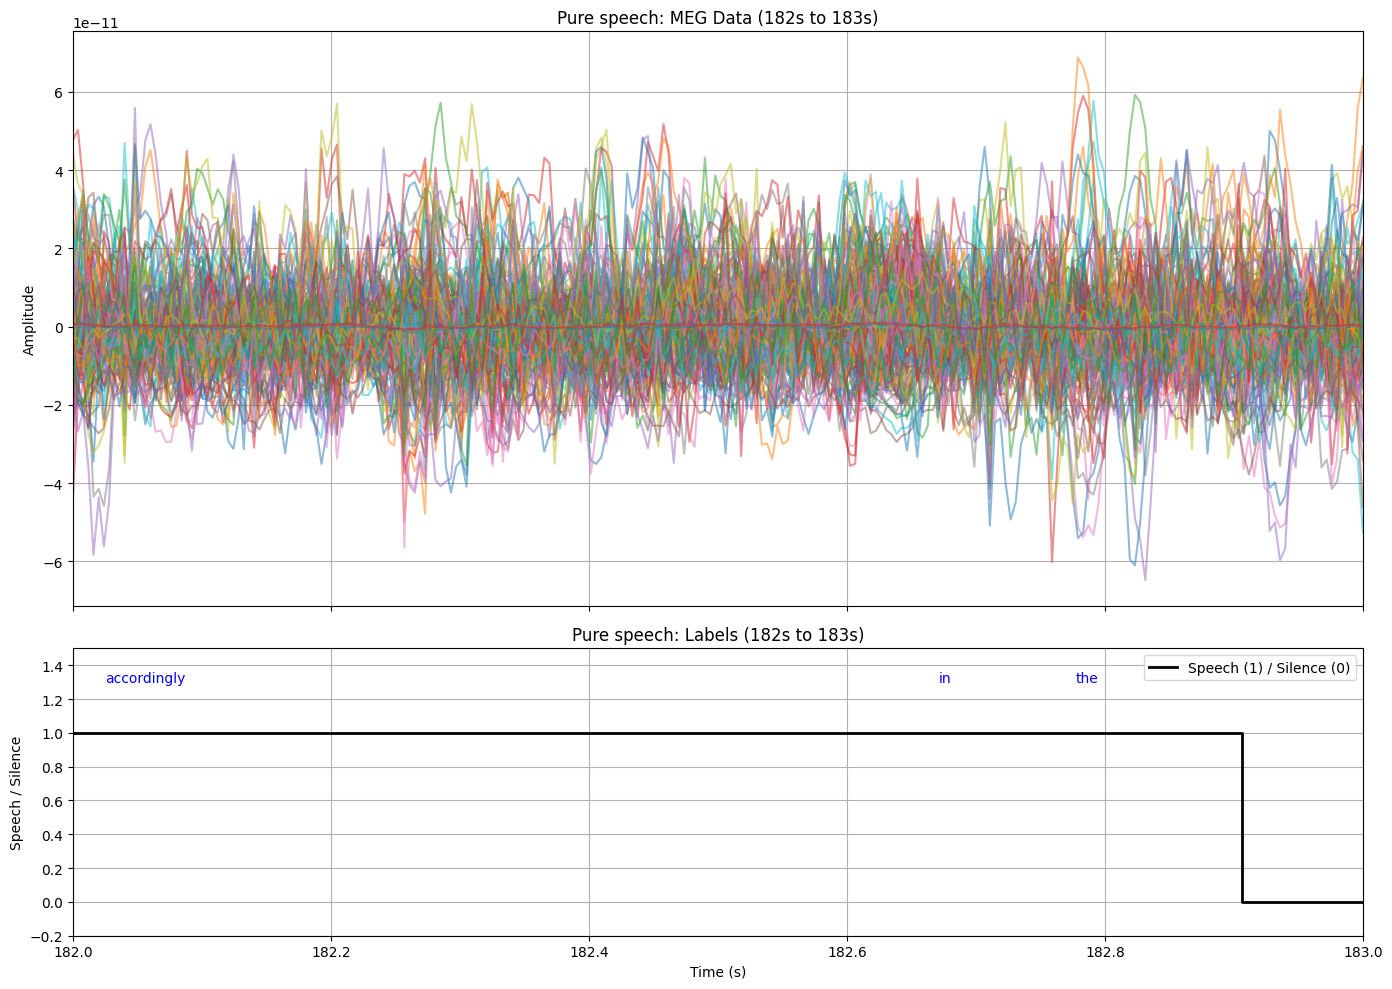

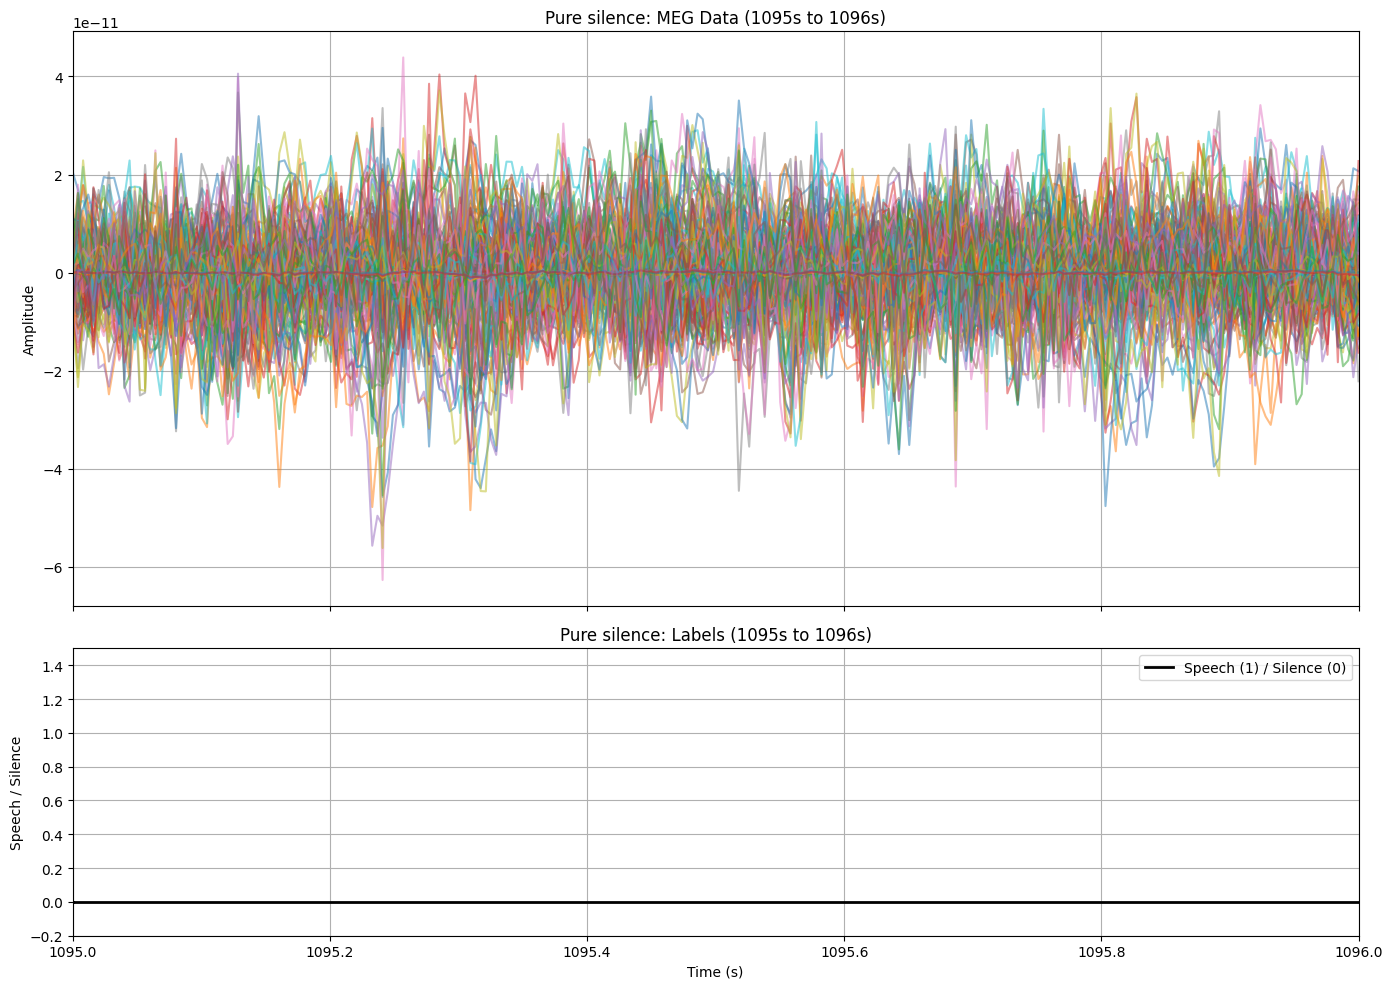

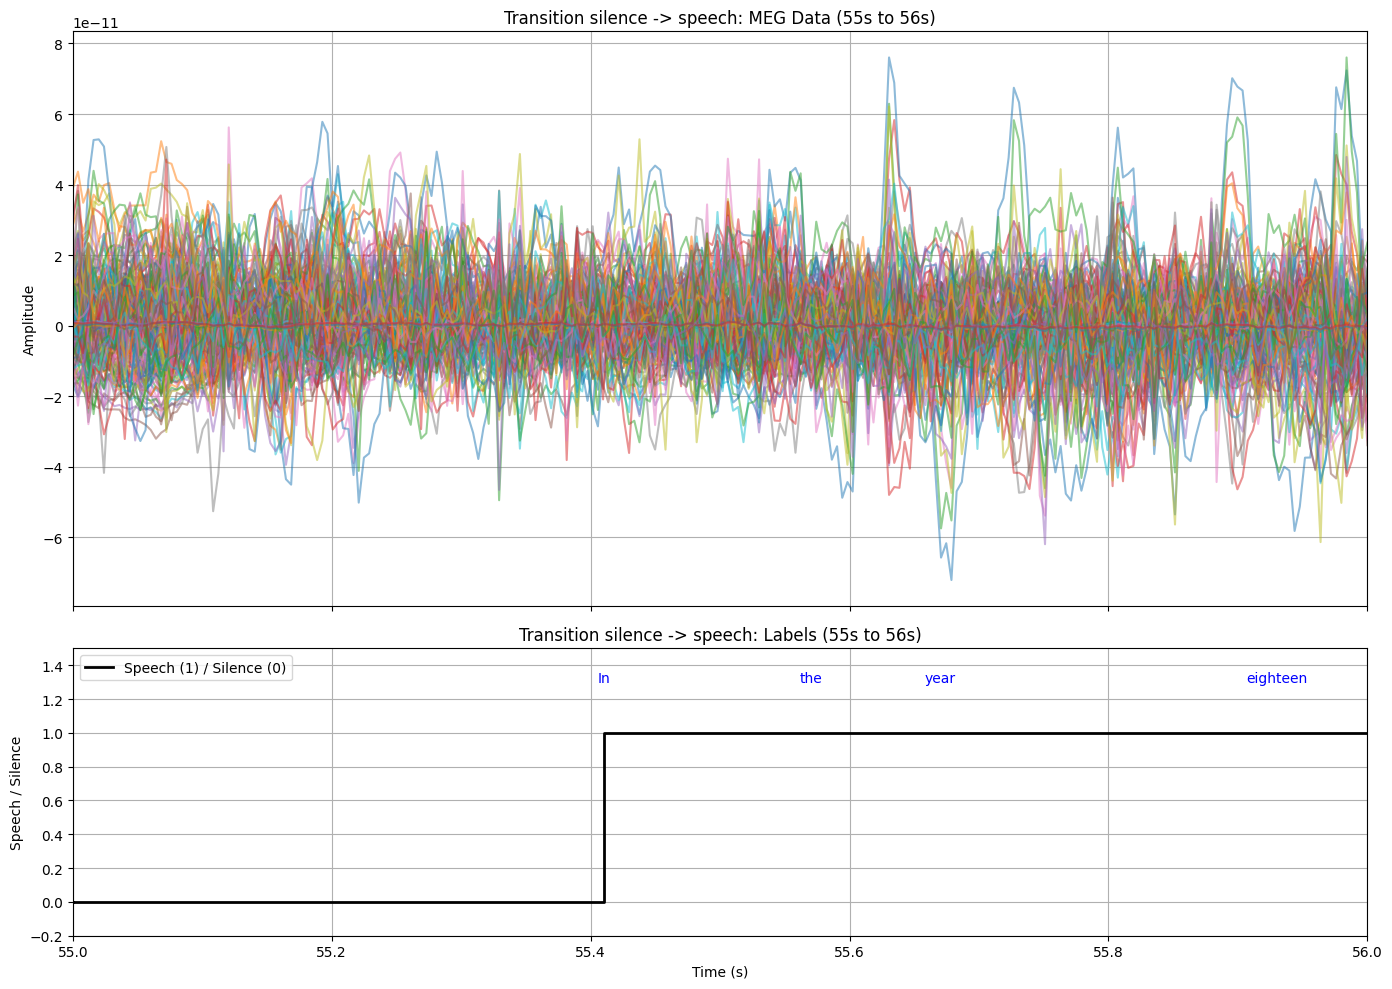

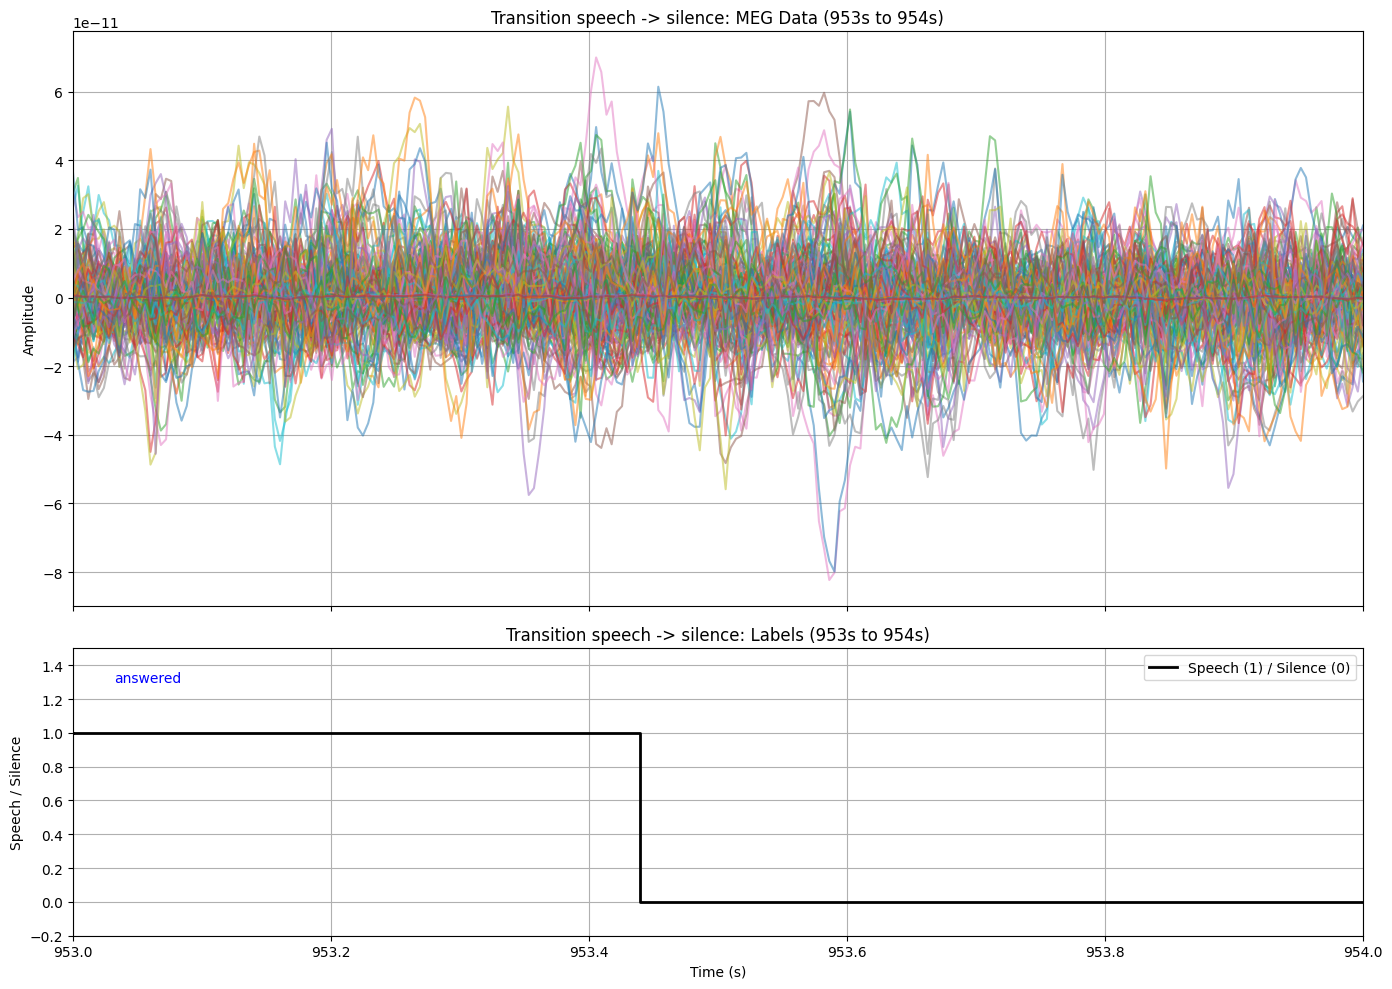

In [7]:
import pandas as pd
import h5py
from mne import create_info


def load_meg_data(hdf5_file_path):
    with h5py.File(hdf5_file_path, 'r') as f:
        raw_data = f['data'][:]
        times = f['times'][:]
    if len(times) >= 2:
        dt = times[1] - times[0]
        sfreq = 1.0 / dt
    else:
        raise ValueError("Not enough time points in 'times' to determine sampling frequency.")
    n_channels = raw_data.shape[0]
    # Create MNE Info object with default channel names.
    channel_names = [f'MEG {i+1:03d}' for i in range(n_channels)]
    info = create_info(ch_names=channel_names, sfreq=sfreq, ch_types=['mag'] * n_channels)
    return raw_data, info


def meg_label_visualization(tsv_data, meg_raw, info, start_time, end_time, title=None, show_phonemes=False, apply_sensor_mask=False):
    """
    Combine MEG data visualization and speech/silence labels.

    Parameters:
      - tsv_data: DataFrame with timing and labeling information.
      - meg_raw: MEG data array (channels x samples).
      - info: MNE Info object containing metadata (including sampling frequency).
      - start_time, end_time: Time window (in seconds) to visualize.
      - title: Optional title for the plots.
      - show_phonemes: Whether to show phoneme annotations.
      - apply_sensor_mask: force applying the sensor mask;
    """
    # --- Optionally apply sensor mask if using filtered data ---
    if apply_sensor_mask:
        try:
            meg_raw = meg_raw[SENSORS_SPEECH_MASK, :]
        except NameError:
            print("SENSORS_SPEECH_MASK is not defined. Proceeding without sensor mask.")

    # --- Process TSV data to build ground-truth labels ---
    tsv_data = tsv_data.copy()
    tsv_data['timemeg'] = tsv_data['timemeg'].astype(float)
    last_before = tsv_data[tsv_data['timemeg'] < start_time].iloc[-1:]
    window_data = tsv_data[(tsv_data['timemeg'] >= start_time) & (tsv_data['timemeg'] <= end_time)]
    filtered_data = pd.concat([last_before, window_data]).sort_values('timemeg')
    if filtered_data.empty:
        filtered_data = pd.DataFrame({'timemeg': [start_time, end_time], 'speech_label': [0, 0]})
    filtered_data['speech_label'] = 0
    filtered_data.loc[filtered_data['kind'].isin(['word', 'phoneme']), 'speech_label'] = 1

    first_value = filtered_data.iloc[0]['speech_label']
    plot_times = [start_time]
    plot_values = [first_value]
    plot_times.extend(filtered_data['timemeg'].tolist())
    plot_values.extend(filtered_data['speech_label'].tolist())
    plot_times.append(end_time)
    plot_values.append(plot_values[-1])
    plot_times = np.array(plot_times)
    plot_values = np.array(plot_values)

    # --- Extract the MEG segment ---
    sfreq = info['sfreq']
    start_sample = int(start_time * sfreq)
    end_sample = int(end_time * sfreq)
    meg_segment = meg_raw[:, start_sample:end_sample]  # shape: (channels, samples)
    time_points = np.linspace(start_time, end_time, meg_segment.shape[1])

    # --- Plotting ---
    fig, axs = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    meg_title = f"{title}: MEG Data ({start_time}s to {end_time}s)" if title else f"MEG Data ({start_time}s to {end_time}s)"
    axs[0].plot(time_points, meg_segment.T, alpha=0.5)
    axs[0].set_title(meg_title)
    axs[0].set_ylabel('Amplitude')
    axs[0].grid(True)

    axs[1].plot(plot_times, plot_values, drawstyle='steps-post', label='Speech (1) / Silence (0)',
                linewidth=2, color='black')
    for _, row in filtered_data.iterrows():
        if pd.isna(row['kind']) or row['kind'] == 'silence':
            continue
        if pd.isna(row['timemeg']) or pd.isna(row['segment']):
            continue
        try:
            if row['kind'] == 'phoneme' and show_phonemes and start_time <= row['timemeg'] <= end_time:
                axs[1].text(row['timemeg'], 1.1, str(row['segment']), fontsize=9, rotation=45, ha='center')
            elif row['kind'] == 'word' and start_time <= row['timemeg'] <= end_time:
                axs[1].text(row['timemeg'], 1.3, str(row['segment']), fontsize=10, rotation=0, ha='center', color='blue')
        except Exception as e:
            print(f"Warning: Could not plot annotation at time {row['timemeg']}: {e}")

    axs[1].set_ylabel('Speech / Silence')
    labels_title = f"{title}: Labels ({start_time}s to {end_time}s)" if title else f"Labels ({start_time}s to {end_time}s)"
    axs[1].set_title(labels_title)
    axs[1].set_ylim(-0.2, 1.5)
    axs[1].set_xlim(start_time, end_time)
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_xlabel('Time (s)')

    plt.tight_layout()
    plt.show()


# Define your file paths (ensure that base_path is defined or replace with actual paths)
tsv_file_path = f"{base_path}/data/Sherlock1/derivatives/events/sub-0_ses-1_task-Sherlock1_run-1_events.tsv"
hdf5_file_path = f"{base_path}/data/Sherlock1/derivatives/serialised/sub-0_ses-1_task-Sherlock1_run-1_proc-bads+headpos+sss+notch+bp+ds_meg.h5"

# Load data from TSV and HDF5 files
tsv_data = pd.read_csv(tsv_file_path, sep='\t')
meg_raw, info = load_meg_data(hdf5_file_path)

# Pure speech
meg_label_visualization(tsv_data, meg_raw, info, start_time=182, end_time=183, title='Pure speech')

# Pure silence
meg_label_visualization(tsv_data, meg_raw, info, start_time=1095, end_time=1096, title='Pure silence')

# Transition silence -> speech
meg_label_visualization(tsv_data, meg_raw, info, start_time=55, end_time=56, title='Transition silence -> speech')

# Transition speech -> silence
meg_label_visualization(tsv_data, meg_raw, info, start_time=953, end_time=954, title='Transition speech -> silence')


While we are only doing a binary classification (speech/non-speech), there are actually four types of signals that might be interesting to look at:
- Pure speech
- Pure silence
- Transition from silence to speech
- Transition from speech to silence

Above, you can see examples of those types taken from the training data.

Note that you can opt into showing individual phonemes by setting `show_phonemes=True` for each of these.

## Training a model
Now that we understand both the data and the speech detection task, let's go forward with arranging the data and training our speech detection model.

### Preparing the data
First, let's set up proper dataloaders with more training data.

For the sake of simplicity (and to speed things up), we will only work with the first and second book, "A Study in Scarlet" (referred to as `Sherlock1`) and "The Sign of the Four" (referred to as `Sherlock2`) in this Colab. For the competition, you can adapt the cell below to load the rest of the dataset, though doing so may not be feasible within the Google Colab free tier.

In our case, since `Sherlock1` consists of 12 sessions in total, we'll use
- sessions 1 through 10 for training,
- session 11 for validation, and
- session 12 as a test set.

We'll also use all 13 sessions of `Sherlock2` as additional training data.

From this point forward, you could theoretically take the sensor data and throw it directly into your favorite model architecture.

In [8]:
from pnpl.datasets import LibriBrainSpeech
from torch.utils.data import DataLoader

# Conditionally set num_workers to avoid multiprocessing issues (try increasing if performance is problematic)
num_workers = 2 if in_colab else 0

# For training, we'll use sessions 1-10 of Sherlock1 and 1-13 of Sherlock2
train_run_keys = [("0",str(i),"Sherlock1","1") for i in range(1, 11)] + [("0",str(i),"Sherlock2","1") for i in range(1, 13) if i!=2]
train_data = LibriBrainSpeech(
  data_path=f"{base_path}/data/",
  include_run_keys = train_run_keys,
  tmin=0.0,
  tmax=0.8,
  preload_files = True
)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=num_workers)


# For validation, we'll use session 11 of Sherlock1
val_data = LibriBrainSpeech(
  data_path=f"{base_path}/data/",
  include_run_keys=[("0","11","Sherlock1","2")],
  standardize=True,
  tmin=0.0,
  tmax=0.8,
  preload_files = True
)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=num_workers)


# For testing, we'll use session 12 of Sherlock1
test_data = LibriBrainSpeech(
  data_path=f"{base_path}/data/",
  include_run_keys=[("0","12","Sherlock1","2")],
  standardize=True,
  tmin=0.0,
  tmax=0.8,
  preload_files = True
)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=num_workers)


print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(val_data))
print("Number of test samples:", len(test_data))

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/317M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/305M [00:00<?, ?B/s]

(…)-0_ses-3_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/700k [00:00<?, ?B/s]

(…)-0_ses-1_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

(…)-0_ses-7_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

(…)-0_ses-6_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/391M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/400M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/316M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/399M [00:00<?, ?B/s]

(…)-0_ses-8_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/429M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/509M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/461M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/280M [00:00<?, ?B/s]

(…)-0_ses-4_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

(…)0_ses-10_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/708k [00:00<?, ?B/s]

(…)-0_ses-5_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/956k [00:00<?, ?B/s]

(…)-0_ses-4_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

(…)0_ses-11_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/809k [00:00<?, ?B/s]

(…)-0_ses-9_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

(…)0_ses-12_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/411M [00:00<?, ?B/s]

(…)-0_ses-5_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/994k [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/225M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/300M [00:00<?, ?B/s]

(…)-0_ses-8_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

(…)-0_ses-9_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/394M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/468M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/466M [00:00<?, ?B/s]

(…)-0_ses-2_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/416M [00:00<?, ?B/s]

(…)0_ses-10_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-0_ses-7_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/400M [00:00<?, ?B/s]

(…)-0_ses-6_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

(…)-0_ses-3_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.53M [00:00<?, ?B/s]

Done!
calculated stats for:  ('0', '2', 'Sherlock1', '1')
calculated stats for:  ('0', '3', 'Sherlock1', '1')
calculated stats for:  ('0', '4', 'Sherlock1', '1')
calculated stats for:  ('0', '5', 'Sherlock1', '1')
calculated stats for:  ('0', '6', 'Sherlock1', '1')
calculated stats for:  ('0', '7', 'Sherlock1', '1')
calculated stats for:  ('0', '8', 'Sherlock1', '1')
calculated stats for:  ('0', '9', 'Sherlock1', '1')
calculated stats for:  ('0', '10', 'Sherlock1', '1')
calculated stats for:  ('0', '1', 'Sherlock2', '1')
calculated stats for:  ('0', '3', 'Sherlock2', '1')
calculated stats for:  ('0', '4', 'Sherlock2', '1')
calculated stats for:  ('0', '5', 'Sherlock2', '1')
calculated stats for:  ('0', '6', 'Sherlock2', '1')
calculated stats for:  ('0', '7', 'Sherlock2', '1')
calculated stats for:  ('0', '8', 'Sherlock2', '1')
calculated stats for:  ('0', '9', 'Sherlock2', '1')
calculated stats for:  ('0', '10', 'Sherlock2', '1')
calculated stats for:  ('0', '11', 'Sherlock2', '1')
cal

(…)0_ses-11_task-Sherlock1_run-2_events.tsv:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/415M [00:00<?, ?B/s]

Done!
calculated stats for:  ('0', '11', 'Sherlock1', '2')


(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/440M [00:00<?, ?B/s]

(…)0_ses-12_task-Sherlock1_run-2_events.tsv:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

Done!
calculated stats for:  ('0', '12', 'Sherlock1', '2')
Number of training samples: 34262
Number of validation samples: 1671
Number of test samples: 1772


In our experience, however, it can pay off to take some time to do additional preparation, so let's do that next.


#### Simplifying the prediction task
As it stands, the dataset expects the model to predict 200 labels per sample - one for every timestep in the input (remember that each sample is composed of 0.8s of data at 250Hz, each containing the sensor values of 306 sensors at that point in time).

Turns out, this is a pretty hard task to learn. So instead, what if the model only had to produce a single prediction per sample — specifically, whether the middle time point in a 200-sample corresponds to speech or not? The input would still be the full 0.8 seconds of MEG data (i.e., 200 time steps), but the model’s output would now be a single label for the central time step. This doesn’t mean we lose the ability to predict labels for all time points. Instead, we can slide a 200-sample “window” across the recording, one timestep at a time, making a prediction for the center of each sample window. In this way, the model still makes predictions for all timesteps, but each one is made with context from both the past and future.

#### Sensor masking
We identified some sensors that provided more activity at relevant frequencies than others during speech periods.
In our experience, only including these sensors in training can lead to improved results. These empirical results track with prior research showing these areas as being important for speech processing.
Note that you can visualize "our" mask in the sensor location visualization above.

Take a look at the comparison below - this does look much more managable, right? (Right-click -> New Tab if the text is too small to read)

![Task comparison](https://neural-processing-lab.github.io/2025-libribrain-competition/speech-colab-task-comparison.png)

We've implemented both of these adaptions into the `FilteredDataset` below, which is the dataset we'll use for training.

In [9]:
import random
import torch
from torch.utils.data import DataLoader
import platform

# These are the sensors we identified as being particularly useful
SENSORS_SPEECH_MASK = [18, 20, 22, 23, 45, 120, 138, 140, 142, 143, 145,
                       146, 147, 149, 175, 176, 177, 179, 180, 198, 271, 272, 275]

class FilteredDataset(torch.utils.data.Dataset):
    """
    Parameters:
        dataset: LibriBrain dataset.
        limit_samples (int, optional): If provided, limits the length of the dataset to this
                          number of samples.
        speech_silence_only (bool, optional): If True, only includes segments that are either
                          purely speech or purely silence (with additional balancing).
        apply_sensors_speech_mask (bool, optional): If True, applies a fixed sensor mask to the sensor
                          data in each sample.
    """
    def __init__(self,
                 dataset,
                 limit_samples=None,
                 disable=False,
                 apply_sensors_speech_mask=True):
        self.dataset = dataset
        self.limit_samples = limit_samples
        self.apply_sensors_speech_mask = apply_sensors_speech_mask

        # These are the sensors we identified:
        self.sensors_speech_mask = SENSORS_SPEECH_MASK

        self.balanced_indices = list(range(len(dataset.samples)))
        # Shuffle the indices
        self.balanced_indices = random.sample(self.balanced_indices, len(self.balanced_indices))

    def __len__(self):
        """Returns the number of samples in the filtered dataset."""
        if self.limit_samples is not None:
            return self.limit_samples
        return len(self.balanced_indices)

    def __getitem__(self, index):
        # Map index to the original dataset using balanced indices
        original_idx = self.balanced_indices[index]
        if self.apply_sensors_speech_mask:
            sensors = self.dataset[original_idx][0][self.sensors_speech_mask]
        else:
            sensors = self.dataset[original_idx][0][:]
        label_from_the_middle_idx = self.dataset[original_idx][1].shape[0] // 2
        return [sensors, self.dataset[original_idx][1][label_from_the_middle_idx]]


# Conditionally set num_workers to avoid multiprocessing issues (try increasing if performance is problematic)
num_workers = 2 if in_colab else 0

print("Filtered dataset:")
train_data_filtered = FilteredDataset(train_data)
train_loader_filtered = DataLoader(train_data_filtered, batch_size=32, shuffle=True, num_workers=num_workers)
print(f"Train data contains {len(train_data_filtered)} samples")

val_data_filtered = FilteredDataset(val_data)
val_loader_filtered = DataLoader(val_data_filtered, batch_size=32, shuffle=False, num_workers=num_workers)
print(f"Validation data contains {len(val_data_filtered)} samples")

test_data_filtered = FilteredDataset(test_data)
test_loader_filtered = DataLoader(test_data_filtered, batch_size=32, shuffle=False, num_workers=num_workers)
print(f"Test data contains {len(test_data_filtered)} samples\n")

# Let's look at the first batch:
first_batch = next(iter(train_loader_filtered))
inputs, labels = first_batch
print("Batch input shape:", inputs.shape)
print("Batch label shape:", labels.shape)

first_input = inputs[0]
first_label = labels[0]
print("\nSingle sample input shape:", first_input.shape)
print("Single sample label is just a single value now!")
print("\nFirst sample input:", first_input)
print("First sample label:", first_label)


Filtered dataset:
Train data contains 34262 samples
Validation data contains 1671 samples
Test data contains 1772 samples

Batch input shape: torch.Size([32, 23, 200])
Batch label shape: torch.Size([32])

Single sample input shape: torch.Size([23, 200])
Single sample label is just a single value now!

First sample input: tensor([[ 0.0224, -0.1040, -0.1021,  ..., -0.0378, -0.0596, -0.0787],
        [-0.2619, -0.2106, -0.6503,  ..., -0.2506, -0.4078, -0.3968],
        [-0.3177, -0.2215, -0.3914,  ..., -0.1718, -0.1808, -0.2203],
        ...,
        [-0.1525, -0.3895, -0.3908,  ..., -0.0934, -0.0337,  0.0460],
        [-0.0164,  0.0046,  0.0332,  ...,  0.0027, -0.0078, -0.0076],
        [ 0.8097,  0.5176,  0.2401,  ...,  0.1543, -0.1522, -0.1190]])
First sample label: tensor(0, dtype=torch.int32)


### Actual training loop
With all that out of the way, let's actually train the model! First, we define the actual model architecture. We will use a 1 Dimensional Convolutional layer - to process the spatial relations between the sensors, followed by a 2 layer LSTM to process the temporal dynamics within each segment.

In [13]:
import torch.nn as nn


class SpeechModel(nn.Module):
    """
    Parameters:
        input_dim (int): Number of channels/features in the input tensor (usually SENSORS_SPEECH_MASK)
        model_dim (int): Dimensionality for the intermediate model representation.
        dropout_rate (float, optional): Dropout probability applied after convolutional and LSTM layers.
        lstm_layers (int, optional): Number of layers in the LSTM module.
        bi_directional (bool, optional): If True, uses a bidirectional LSTM; otherwise, a unidirectional LSTM.
        batch_norm (bool, optional): Indicates whether to use batch normalization.

    """
    def __init__(self, input_dim, model_dim, dropout_rate=0.3, lstm_layers = 1, bi_directional = False, batch_norm=False):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels=input_dim,
            out_channels=model_dim,
            kernel_size=3,
            padding=1,
        )
        self.lstm_layers = lstm_layers
        self.batch_norm = nn.BatchNorm1d(num_features=model_dim) if batch_norm else nn.Identity()
        self.conv_dropout = nn.Dropout(p=dropout_rate)
        self.lstm = nn.LSTM(
            input_size=model_dim,
            hidden_size=model_dim,
            num_layers=self.lstm_layers,
            dropout=dropout_rate,
            batch_first=True,
            bidirectional=bi_directional
        )
        self.lstm_dropout = nn.Dropout(p=dropout_rate)
        self.speech_classifier = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.conv_dropout(x)
        # LSTM expects (batch, seq_len, input_size)
        output, (h_n, c_n) = self.lstm(x.permute(0, 2, 1))
        last_layer_h_n = h_n
        if self.lstm_layers > 1:
            # handle more than one layer
            last_layer_h_n = h_n[-1, :, :]
            last_layer_h_n = last_layer_h_n.unsqueeze(0)
        output = self.lstm_dropout(last_layer_h_n)
        output = output.flatten(start_dim=0, end_dim=1)
        x = self.speech_classifier(output)
        return x

(…)-0_ses-3_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/700k [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/225M [00:00<?, ?B/s]

Next, let's wrap the model in a [LightningModule](https://lightning.ai/docs/pytorch/LTS/common/lightning_module.html) to save ourselves from some boilerplate.
This is also where we define our loss function (BCE with label smoothing) and optimizer (AdamW).

In [14]:
import lightning as L
import torch
import torch.nn as nn
import torchmetrics
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, jaccard_score
from torchmetrics import Precision, Recall, F1Score
from lightning.pytorch.callbacks import Callback
import numpy as np
from torchmetrics.functional import recall


class SpeechClassifier(L.LightningModule):
    """
    Parameters:
        input_dim (int): Number of input channels/features. This is passed to the underlying SpeechModel.
        model_dim (int): Dimensionality of the intermediate model representation.
        learning_rate (float, optional): Learning rate for the optimizer.
        weight_decay (float, optional): Weight decay for the optimizer.
        batch_size (int, optional): Batch size used during training and evaluation.
        dropout_rate (float, optional): Dropout probability applied after convolutional and LSTM layers.
        smoothing (float, optional): Label smoothing factor applied in the BCEWithLogits loss.
        pos_weight (float, optional): Weight for the positive class in the BCEWithLogits loss.
        batch_norm (bool, optional): Indicates whether to use batch normalization.
        lstm_layers (int, optional): Number of layers in the LSTM module within the SpeechModel.
        bi_directional (bool, optional): If True, uses a bidirectional LSTM in the SpeechModel; otherwise, uses a unidirectional LSTM.
    """

    def __init__(self, input_dim, model_dim, learning_rate=1e-3, weight_decay=0.01, batch_size=32, dropout_rate=0.3, smoothing=0.1, pos_weight = 1.0 , batch_norm = False, lstm_layers = 1, bi_directional = False):
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.model = SpeechModel(input_dim, model_dim, dropout_rate=dropout_rate, lstm_layers=lstm_layers, bi_directional=bi_directional, batch_norm=batch_norm)

        self.loss_fn = BCEWithLogitsLossWithSmoothing(smoothing=smoothing, pos_weight = pos_weight)

        self.val_step_outputs = []
        self.test_step_outputs = {}


    def forward(self, x):
            return self.model(x)

    def _shared_eval_step(self, batch, stage):
        x = batch[0]
        y = batch[1] # (batch, seq_len)

        logits = self(x)
        loss = self.loss_fn(logits, y.unsqueeze(1).float())
        probs = torch.sigmoid(logits)
        y_probs = probs.detach().cpu()

        y_true = batch[1].detach().cpu()
        meg = x.detach().cpu()

        self.log(f'{stage}_loss', loss, on_step=False, on_epoch=True, batch_size=self.batch_size)
        return loss


    def training_step(self, batch, batch_idx):
        return self._shared_eval_step(batch, "train")


    def validation_step(self, batch, batch_idx):
        return self._shared_eval_step(batch, "val")


    def test_step(self, batch, batch_idx):
        x = batch[0]
        y = batch[1]  # (batch, seq_len)

        # ugly, taking care of only one label
        if len(y.shape) != 1:
            y = y.flatten(start_dim=0, end_dim=1).view(-1, 1)  # (batch, seq_len) -> (batch * seq_len, 1)
        else:
            y = y.unsqueeze(1)

        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        probs = torch.sigmoid(logits)

        # Append data to the defaultdict
        # Ensure keys exist before appending
        if "y_probs" not in self.test_step_outputs:
            self.test_step_outputs["y_probs"] = []
        if "y_true" not in self.test_step_outputs:
            self.test_step_outputs["y_true"] = []
        if "meg" not in self.test_step_outputs:
            self.test_step_outputs["meg"] = []

        # Append data
        if y.shape[-1] != 1:
            self.test_step_outputs["y_probs"].extend(
                probs.detach().view(x.shape[0], x.shape[-1]).cpu())  # (batch, seq_len)
        else:
            self.test_step_outputs["y_probs"].extend(
                probs.detach().view(x.shape[0], 1).cpu())  # (batch, seq_len)

        self.test_step_outputs["y_true"].extend(batch[1].detach().cpu())  # (batch, seq_len)
        self.test_step_outputs["meg"].extend(x.detach().cpu())  # MEG data (batch, channels, seq_len)

        return self._shared_eval_step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer


class BCEWithLogitsLossWithSmoothing(nn.Module):
    def __init__(self, smoothing=0.1, pos_weight = 1.0):
        """
        Binary Cross-Entropy Loss with Deterministic Label Smoothing.

        Parameters:
            smoothing (float): Smoothing factor. Must be between 0 and 1.
            pos_weight (float): Weight for the positive class.
        """
        super().__init__()
        self.smoothing = smoothing
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))

    def forward(self, logits, target):
        target = target.float()  # Ensure target is a float tensor
        target_smoothed = target * (1 - self.smoothing) + self.smoothing * 0.5
        return self.bce_loss(logits, target_smoothed)

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/300M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/466M [00:00<?, ?B/s]

Finally, here's the training loop. We'll either use a basic CSVLogger when running locally or the built-in Tensorboard in Colab for logging to keep things self-contained.

In [15]:
import os
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks import EarlyStopping


# Setup paths for logs and checkpoints
LOG_DIR = f"{base_path}/lightning_logs"
CHECKPOINT_PATH = f"{base_path}/models/speech_model.ckpt"

# Minimal logging setup
logger = CSVLogger(
    save_dir=LOG_DIR,
    name="",
    version=None,
)

if in_colab:  # In Colab, we use the built-in Tensorboard setup
    logger = TensorBoardLogger(
        save_dir=LOG_DIR,
        name="",
        version=None,
        default_hp_metric=True
    )
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
    %load_ext tensorboard
    %tensorboard --logdir $LOG_DIR


# Set a fixed seed for reproducibility
L.seed_everything(42)

# Initialize the SpeechClassifier model
# Note: Feel free to play around with the hyperparameters here!
model = SpeechClassifier(
    input_dim=len(SENSORS_SPEECH_MASK),
    model_dim=100,
    learning_rate=1e-3,
    dropout_rate=0.5,
    lstm_layers=2,
    weight_decay=0.01,
    batch_norm=False,
    bi_directional=False
)

# Log Hyperparameters
logger.log_hyperparams(model.hparams)

# Optional: Early stopping
#           In our testing, we experienced a lot of issues with overfitting.
#           We resolve this by stopping training if validation loss stops going down
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
    verbose=True,
    mode="min"
)

# Initialize trainer
trainer = L.Trainer(
    devices="auto",
    max_epochs=15,
    logger=logger,
    enable_checkpointing=True,
    callbacks=[early_stopping_callback]
)

# Actually train the model
trainer.fit(model, train_loader_filtered, val_loader_filtered)
# Save trained model weights
trainer.save_checkpoint(CHECKPOINT_PATH)
# Test trained model
trainer.test(model, test_loader_filtered)


Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NameError: name 'train_loader_filtered' is not defined

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/411M [00:00<?, ?B/s]

If you instead wish to load pretrained model weights, you can do so here:

In [16]:
import os
import requests

# Setup checkpoint path
CHECKPOINT_PATH = f"{base_path}/models/speech_model.ckpt"

# Download the model (descomenta estas líneas)
model_url = "https://neural-processing-lab.github.io/2025-libribrain-competition/speech_model.ckpt"
response = requests.get(model_url)
os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)
with open(CHECKPOINT_PATH, "wb") as f:
    f.write(response.content)
print("Download of model checkpoint complete.")

# Set a fixed seed for reproducibility (just in case)
L.seed_everything(42)

# Load the SpeechClassifier model from checkpoint
model = SpeechClassifier.load_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    input_dim=len(SENSORS_SPEECH_MASK),
    model_dim=100,
    learning_rate=1e-3,
    dropout_rate=0.5,
    lstm_layers=2,
    weight_decay=0.01,
    batch_norm=False,
    bi_directional=False
)

# Initialize trainer and test loaded model
trainer = L.Trainer(devices="auto")
trainer.test(model, test_loader_filtered)

Seed set to 42


Download of model checkpoint complete.


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jpdevopti/Repositorios/LibriBrian_Competition/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


NameError: name 'test_loader_filtered' is not defined

## Evaluating the model
You've now trained your model - congratulations! Let's check out the test accuracy on unseen data:

In [ ]:
trainer.test(model, dataloaders=test_loader_filtered)

NameError: name 'test_loader_filtered' is not defined

(…)0_ses-10_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/708k [00:00<?, ?B/s]

(…)-0_ses-6_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

(…)-0_ses-4_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/280M [00:00<?, ?B/s]

(…)-0_ses-3_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.53M [00:00<?, ?B/s]

(…)-0_ses-2_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

(…)0_ses-12_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/394M [00:00<?, ?B/s]

(…)-0_ses-4_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

(…)-0_ses-7_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/509M [00:00<?, ?B/s]

(…)-0_ses-9_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/399M [00:00<?, ?B/s]

(…)0_ses-10_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/316M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-0_ses-8_task-Sherlock1_run-1_events.tsv:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

(…)-0_ses-8_task-Sherlock2_run-1_events.tsv:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/461M [00:00<?, ?B/s]

(…)2Bheadpos%2Bsss%2Bnotch%2Bbp%2Bds_meg.h5:   0%|          | 0.00/317M [00:00<?, ?B/s]

Well, that sounds good but doesn't really tell us anything, so let's take a deeper look at the model's performance. We'll start by running some predictions:

In [16]:
model.eval()
all_y_true = []
all_y_probs = []

with torch.no_grad():
    # # Uncomment to compute statistics on training (might be slow!)
    # for batch in train_loader_filtered:
    #     x, y = batch
    #     logits = model(x)
    #     probs = torch.sigmoid(logits)

    #     all_y_true.append(y)
    #     all_y_probs.append(probs)

    # Uncomment to compute statistics on validation set
    for batch in val_loader_filtered:
        x, y = batch
        logits = model(x)
        probs = torch.sigmoid(logits)

        all_y_true.append(y)
        all_y_probs.append(probs)

    # Uncomment to compute statistics on test set
    # for batch in test_loader_filtered:
    #     x, y = batch
    #     logits = model(x)
    #     probs = torch.sigmoid(logits)

    #     all_y_true.append(y)
    #     all_y_probs.append(probs)


y_true = torch.cat(all_y_true, dim=0)
y_probs = torch.cat(all_y_probs, dim=0)

print("Ready to compute statistics with " + str(len(y_true)) + " samples.")

Ready to compute statistics with 1671 samples.


Let's plot [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. Ideally, we want this graph to immediately rise to (0/1) at the start of the graph.

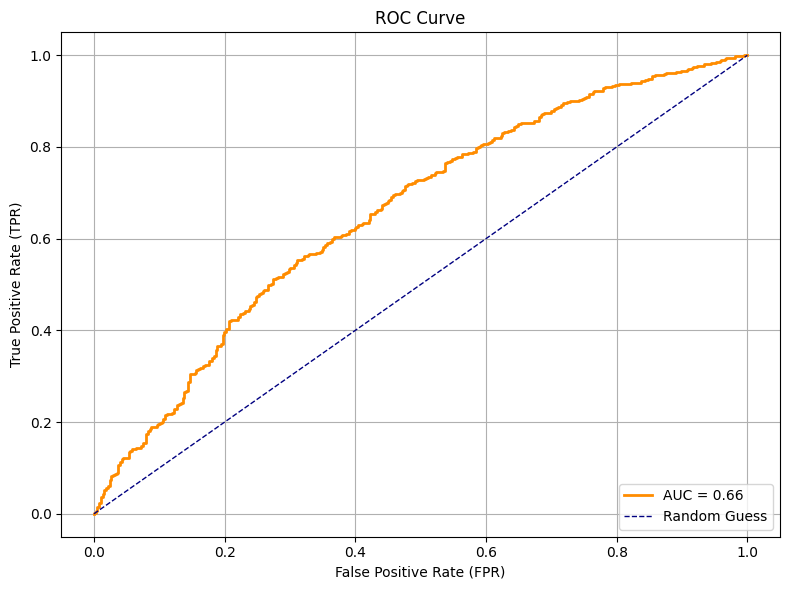


AUC is 0.6581512363427257


In [17]:
import torch
import matplotlib.pyplot as plt


def plot_auc_roc(labels, probs, title="ROC Curve"):
    """
    Generates an AUC-ROC plot.

    Args:
        labels (torch.Tensor or np.ndarray): Ground truth binary labels (shape: [num_segments, sequence_length]).
        probs (torch.Tensor or np.ndarray): Predicted probabilities for the positive class (shape: [num_segments, sequence_length]).
        title (str): Title of the plot.
    """
    # Convert to NumPy if necessary
    if not isinstance(labels, np.ndarray):
        labels = labels.cpu().numpy()
    if not isinstance(probs, np.ndarray):
        probs = probs.cpu().numpy()

    # Flatten the data to treat all predictions equally
    labels_flat = labels.flatten()
    probs_flat = probs.flatten()

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(labels_flat, probs_flat)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label="Random Guess")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    fig = plt.gcf()

    return fig, roc_auc


fig, roc_auc = plot_auc_roc(y_true, y_probs)
plt.show()
print("\nAUC is " + str(roc_auc))



Note that even poor models may look okay due to the imbalance of the dataset. Let's take a look at our models predictions in a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

C:\Users\jp\AppData\Local\Temp\ipykernel_10452\2791201143.py:48: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.

C:\Users\jp\AppData\Local\Temp\ipykernel_10452\2791201143.py:49: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.



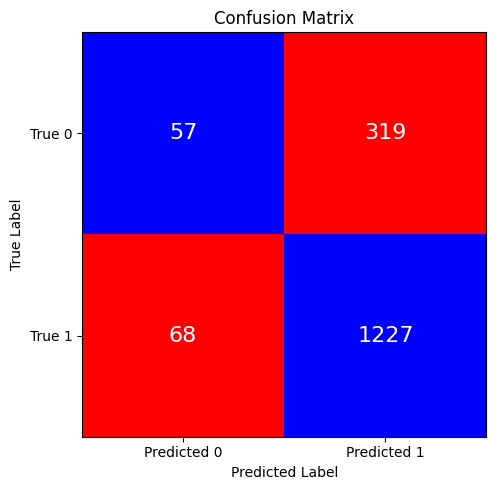


IoU (Jaccard Index) is 0.7602230483271375


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import jaccard_score


def plot_confusion_matrix_1s_0s(labels, preds):
    labels = labels.flatten()
    preds = preds.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds, labels=[0, 1])

    # Create a binary matrix indicating correct predictions (diagonals) as 1 and incorrect as 0
    cell_type = np.zeros_like(cm)
    for i in range(cm.shape[0]):
        cell_type[i, i] = 1

    # Define a custom colormap: 0 -> red (incorrect), 1 -> blue (correct)
    cmap = ListedColormap(['red', 'blue'])

    # Plot using matplotlib's imshow
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(cell_type, cmap=cmap, vmin=-0.5, vmax=1.5)

    # Overlay the confusion matrix numbers on top of the colored cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center', color='white', fontsize=16)

    # Set tick labels
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(["Predicted 0", "Predicted 1"])
    ax.set_yticklabels(["True 0", "True 1"])
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title("Confusion Matrix")
    fig.tight_layout()

    return fig


# Assuming your test_step_outputs dict has been populated from trainer.test(model, test_loader)
# Convert the collected outputs into numpy arrays and flatten them if needed
y_true = np.array(y_true)
y_probs = np.array(y_probs)

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred = (y_probs >= 0.5).astype(int)

# Use the provided function to plot the confusion matrix
fig = plot_confusion_matrix_1s_0s(y_true, y_pred)

# Display the plot
plt.show()


iou = jaccard_score(y_true, y_pred, average="binary")
print("\nIoU (Jaccard Index) is " + str(iou))


## That's it! 🥳
Thanks for taking the time to look at and/or participate in our competition. If this caught your interest, you might also want to take a look at the more advanced version of the task, focussed on Phoneme Classification - you can find the corresponding Colab [here](https://neural-processing-lab.github.io/2025-libribrain-competition/links/phoneme-colab). If you have any open questions, please get in touch through [our Discord server](https://neural-processing-lab.github.io/2025-libribrain-competition/links/discord). Ready to submit your model? You might want to take a look at the [submission tutorial](https://neural-processing-lab.github.io/2025-libribrain-competition/links/submission-colab) or the [LibriBrain competition website](https://neural-processing-lab.github.io/2025-libribrain-competition).